# Connect to Drive to import data.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# install tensorFlow and keras

In [ ]:
!pip install tensorflow
!pip install keras
!pip install numpy

# Create dataframes and basic preprocessing

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer

# Load the dataframe
fake = pd.read_csv('drive/MyDrive/Colab Notebooks/Fake.csv')
true = pd.read_csv('drive/MyDrive/Colab Notebooks/True.csv')
fake['target'] = 'fake'
true['target'] = 'true'

df = pd.concat([fake, true]).reset_index(drop = True)

# Create a TfidfVectorizer object
vectorizer = TfidfVectorizer(stop_words='english', max_features=1000)

# Fit the vectorizer to the text data
vectorizer.fit(df['text'])

TfidfVectorizer(max_features=1000, stop_words='english')

In [ ]:
# Removing the date (we won't use it for the analysis)
df.drop(["date"],axis=1,inplace=True)
# Removing the title (we will only use the text)
df.drop(["title"],axis=1,inplace=True)
# Convert to lowercase
df['text'] = df['text'].apply(lambda x: x.lower())
# Remove punctuation

import string

def punctuation_removal(text):
    all_list = [char for char in text if char not in string.punctuation]
    clean_str = ''.join(all_list)
    return clean_str

df['text'] = df['text'].apply(punctuation_removal)
# Removing stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop = stopwords.words('english')

df['text'] = df['text'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Model building initialization: Tokenising, dataset classification and Glove Embedding

In [ ]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, Bidirectional, LSTM, Dense
from tensorflow.keras.models import Sequential
from sklearn.model_selection import train_test_split


In [ ]:
# Tokenization
max_words = 10000  # Maximum number of words in your vocabulary
tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(df['text'])

# Sequencing
sequences = tokenizer.texts_to_sequences(df['text'])
max_sequence_length = 5000
X = pad_sequences(sequences, maxlen=max_sequence_length)

# Labels
y = pd.get_dummies(df['target'], columns=['fake', 'true'])

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
embedding_dim = 100
embedding_index = {}
with open('drive/MyDrive/Colab Notebooks/glove_6B_100d.txt', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs

# Tokenization
word_index = tokenizer.word_index
num_words = min(max_words, len(word_index)) + 1
embedding_matrix = np.zeros((num_words, embedding_dim))

for word, i in word_index.items():
    if i >= max_words:
        continue
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector


# BiLSTM Model

In [ ]:
# Model Ctreation
BiLSTMModel = Sequential()
BiLSTMModel.add(Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
BiLSTMModel.add(Bidirectional(LSTM(64, return_sequences=True)))
BiLSTMModel.add(Bidirectional(LSTM(64)))
BiLSTMModel.add(Dense(2, activation='softmax'))

BiLSTMModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])


BiLSTMModel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)


loss, accuracy = BiLSTMModel.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


Epoch 1/5
562/562 [==============================] - 349s 596ms/step - loss: 0.1861 - accuracy: 0.9265 - val_loss: 0.0702 - val_accuracy: 0.9752
Epoch 2/5
562/562 [==============================] - 338s 601ms/step - loss: 0.0805 - accuracy: 0.9687 - val_loss: 0.0191 - val_accuracy: 0.9954
Epoch 3/5
562/562 [==============================] - 338s 602ms/step - loss: 0.0522 - accuracy: 0.9818 - val_loss: 0.2296 - val_accuracy: 0.8998
Epoch 4/5
562/562 [==============================] - 329s 585ms/step - loss: 0.0249 - accuracy: 0.9925 - val_loss: 0.0085 - val_accuracy: 0.9977
Epoch 5/5
281/281 [==============================] - 59s 210ms/step - loss: 0.0090 - accuracy: 0.9976
Loss: 0.008984480984508991
Accuracy: 0.9975501298904419


# ROC Curve

281/281 [==============================] - 59s 204ms/step
ROC AUC: 0.9998830906901336


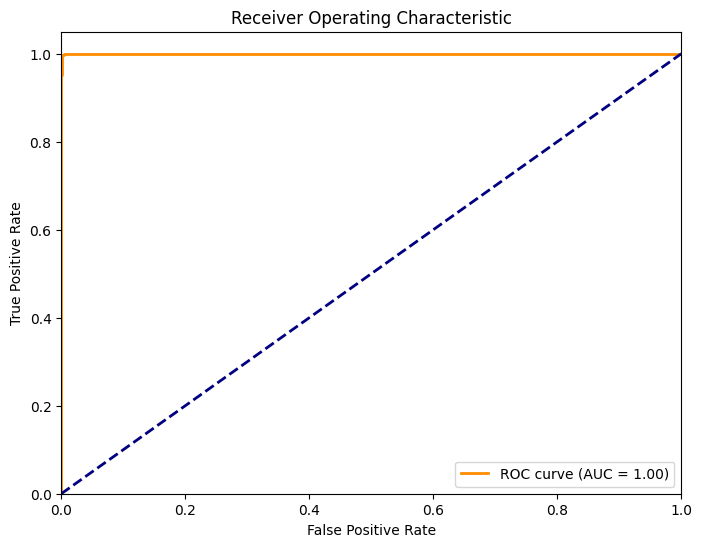

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

y_pred_bilstm = BiLSTMModel.predict(X_test)

y_true_bilstm = y_test['fake']  # Use 'fake' column as the label

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_bilstm, y_pred_bilstm[:, 0])

# Calculate ROC AUC
roc_auc = roc_auc_score(y_true_bilstm, y_pred_bilstm[:, 0])

# Print AUC
print(f'ROC AUC: {roc_auc}')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# BiGRU Model Creation

In [ ]:
from tensorflow.keras.layers import GRU

BiGRUModel = Sequential()
BiGRUModel.add(Embedding(input_dim=num_words, output_dim=embedding_dim, weights=[embedding_matrix], input_length=max_sequence_length, trainable=False))
BiGRUModel.add(Bidirectional(GRU(64, return_sequences=True)))
BiGRUModel.add(Bidirectional(GRU(64)))
BiGRUModel.add(Dense(2, activation='softmax'))

BiGRUModel.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

BiGRUModel.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=5, batch_size=64)

loss, accuracy = BiGRUModel.evaluate(X_test, y_test)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')


Epoch 1/5
562/562 [==============================] - 336s 585ms/step - loss: 0.0673 - accuracy: 0.9736 - val_loss: 0.0053 - val_accuracy: 0.9987
Epoch 2/5
562/562 [==============================] - 327s 583ms/step - loss: 0.0078 - accuracy: 0.9981 - val_loss: 0.0040 - val_accuracy: 0.9990
Epoch 3/5
562/562 [==============================] - 318s 566ms/step - loss: 0.0079 - accuracy: 0.9981 - val_loss: 0.0050 - val_accuracy: 0.9990
Epoch 4/5
562/562 [==============================] - 328s 583ms/step - loss: 0.0051 - accuracy: 0.9987 - val_loss: 0.0032 - val_accuracy: 0.9994
Epoch 5/5
281/281 [==============================] - 58s 207ms/step - loss: 0.0047 - accuracy: 0.9990
Loss: 0.004662438295781612
Accuracy: 0.9989977478981018


# ROC Curve

281/281 [==============================] - 58s 201ms/step
ROC AUC: 0.9999899507742157


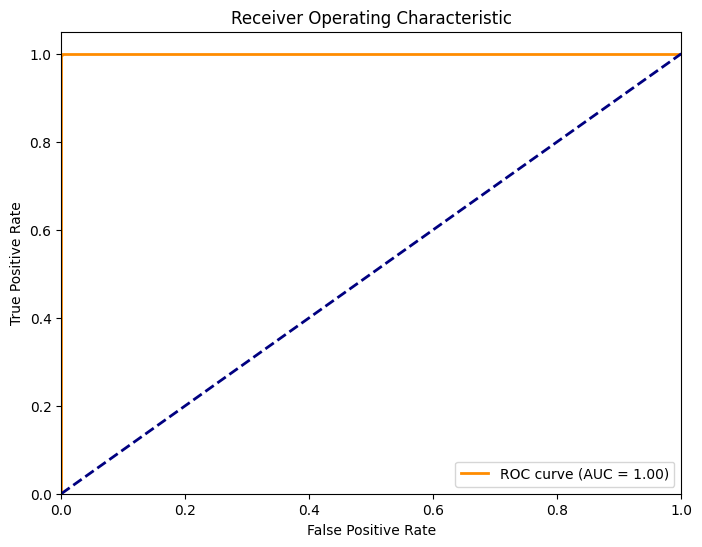

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt


y_pred_bigru = BiGRUModel.predict(X_test)

y_true_bigru = y_test['fake']  # Use 'fake' column as the label

# Calculate ROC curve
fpr, tpr, thresholds = roc_curve(y_true_bigru, y_pred_bigru[:, 0])

# Calculate ROC AUC
roc_auc = roc_auc_score(y_true_bigru, y_pred_bigru[:, 0])

# Print AUC
print(f'ROC AUC: {roc_auc}')

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc='lower right')
plt.show()


# Ensemble BiLSTM and BiGRU model

In [ ]:
ensemble_predictions = (y_pred_bilstm + y_pred_bigru) / 2

from sklearn.metrics import roc_auc_score

y_true_ensemble = y_test['fake']
ensemble_auc = roc_auc_score(y_true_ensemble, ensemble_predictions[:, 0])

print(f'Ensemble ROC AUC: {ensemble_auc}')

Ensemble ROC AUC: 0.99996552419075
